In [1]:
from matplotlib import pyplot as plt
import imageio
import numpy as np

# Triangulating points from images

First, some math.

The clock tower at the ferry building has a 6.7 meter-wide clock face. From the intersection of Beale and Market 469 meters away, the clock sweeps out:

$$ \arctan( 6.7 / 459 ) = 0.89 \deg $$

In the frame taken at Beale and Market, the clock tower is 17 pixels wide. Thus the angular resolution of the image is:

$$ \frac{0.89 \deg}{17 pixels} \approx 0.048 \deg / pixels$$

The frame is 570 pixels wide. Thus the entire frame is $570 pixels \cdot 0.048 \deg/pixels = 27.4 \deg$

This translates to a focal length $f$ of 2.05; or (in this case) $570 pixels\cdot2.05 = 1168.5 pixels$.

This will be useful later.

In [2]:
# grab a couple of image stills

still1 = 255-imageio.imread("data/still1.png")[:,:,0]
still2 = 255-imageio.imread("data/still2.png")[:,:,0]

The first image points towards the streetcar turntable at the ferry terminal, at 3rd and Market:

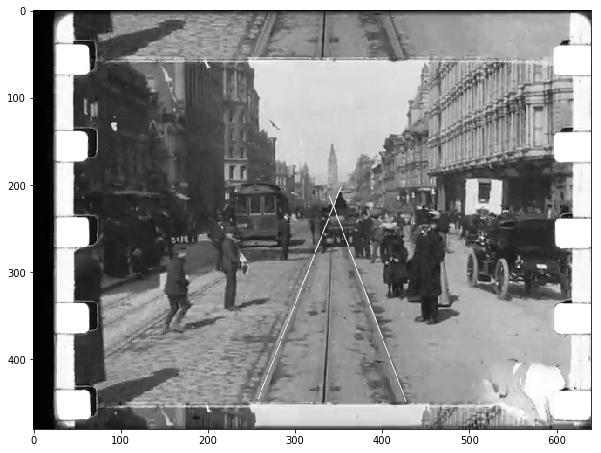

In [3]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow( still1, cmap="Greys" )

The second points in the same direction, 500 meters down market street at 1st and Market.

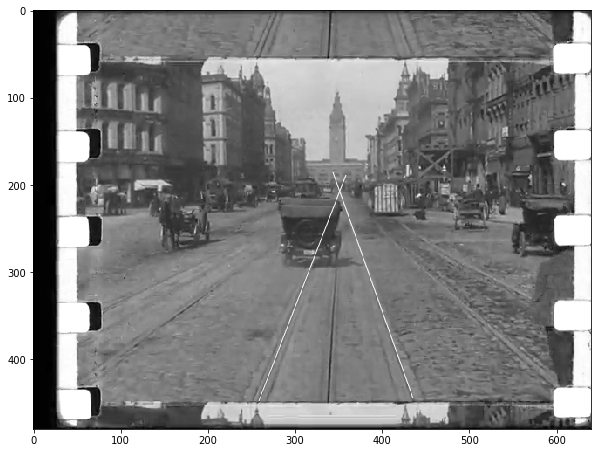

In [4]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow( still2, cmap="Greys" )

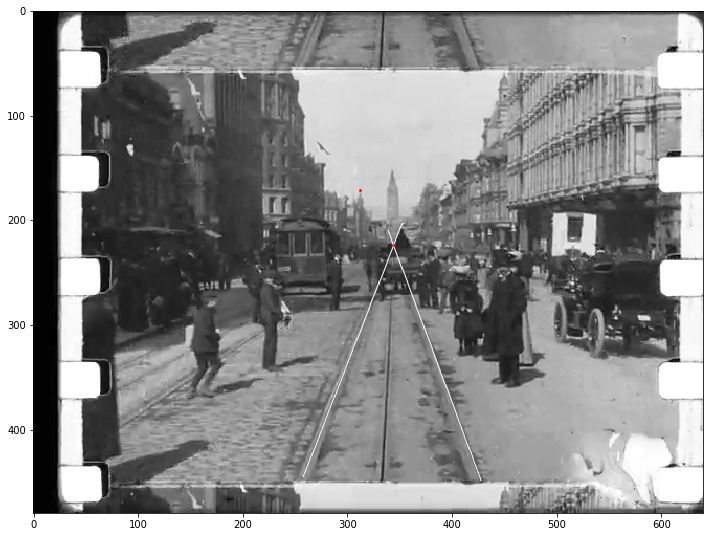

In [5]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow( still1, cmap="Greys" )

origin1 = np.array( [344, 224] )
pt1 = np.array( [-32,-53] )
ax.scatter( *origin1, s=3, c="red"  )
ax.scatter( *(origin1+pt1), s=3, c="red"  )

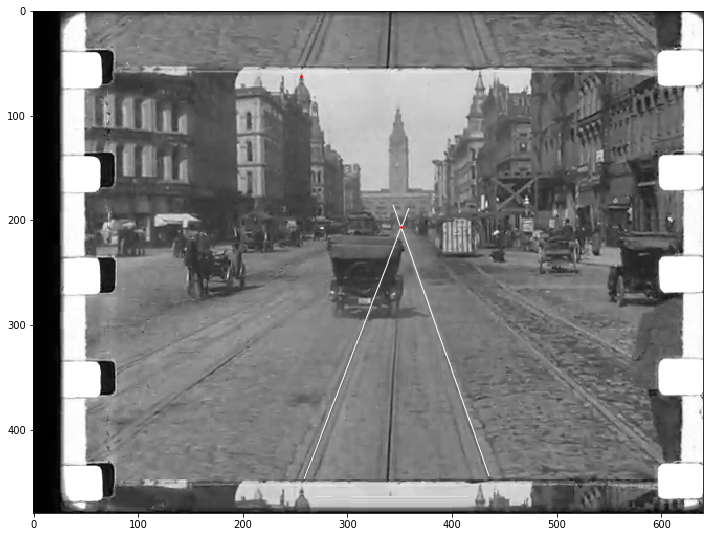

In [6]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow( still2, cmap="Greys" )

origin2 = np.array( [351, 206] )
pt2 = np.array( [-95,-144] )
ax.scatter( *origin2, s=3, c="red"  )
ax.scatter( *(origin2+pt2), s=3, c="red"  )

Finally let's define a coordinate world space:

* +x to the right
* +y down
* +z along market towards the ferry building

(0,0,0) is on the ground at 3rd and Market.

At this point we have:

In [7]:
#focal length
f = 1168.5 #pixels

camera_pos1 = np.array( (0,0,0) )
camera_pos2 = np.array( (0,0,500) )
cam = np.stack( [camera_pos1, camera_pos2] )

pt1 = np.array( [-32,-53] )
pt2 = np.array( [-95,-144] )
pt = np.stack( [pt1, pt2] )

We're curious about the world-fixed position of the point at the apex of that funny looking building.

Given the point in world coordinatres $a$ and camera position in world coordinates $c$, the point in camera coordinates $d$ is

$$d = a-c$$

The position on the screen is:

$$x = f\frac{d_x}{d_z}$$
$$y = f\frac{d_y}{d_z}$$



In [141]:
a_guess = np.array( [-22.015893392016636, -34.86997982761787, 779.1428571428572] )

In [142]:
d_guess = a_guess - cam

In [143]:
x_guess = f*(d_guess[:,0] / d_guess[:,2])
y_guess = f*(d_guess[:,1] / d_guess[:,2])

In [144]:
pt_guess = np.stack( [x_guess, y_guess] ).T
pt_guess

array([[ -33.01778511,  -52.29537954],
       [ -92.1591607 , -145.9667349 ]])

In [145]:
pt

array([[ -32,  -53],
       [ -95, -144]])

In [109]:
loss = (((pt-pt_guess)**2).sum(axis=1)**0.5).sum()
loss

70.41020713206902

which expands to

$$x = f\frac{a_x-c_x}{a_z-c_z}$$
$$y = f\frac{a_y-c_y}{a_z-c_z}$$

fidget until

$$- fa_x + 0a_y + xa_z= xc_z - fc_x$$
$$0a_x - fa_y + ya_z= yc_z - fc_y$$

$$
\begin{bmatrix}
    - f       & 0 & x  \\
    0       & -f & y  \\
\end{bmatrix} a = 
\begin{bmatrix}
    xc_z - fc_x  \\
    yc_z - fc_y \\
\end{bmatrix}
$$

For multiple camera/observation pairs just stack the matrices:

$$
\begin{bmatrix}
    - f       & 0 & x_1  \\
    0       & -f & y_1  \\
    - f       & 0 & x_2  \\
    0       & -f & y_2  \\
\end{bmatrix} a = 
\begin{bmatrix}
    x_1c_{z1} - fc_{x1}  \\
    y_1c_{z1} - fc_{y1} \\
    x_2c_{z2} - fc_{x2}  \\
    y_2c_{z2} - fc_{y2} \\
\end{bmatrix}
$$

In [121]:
x1, y1 = pt1
x2, y2 = pt2
cx1, cy1, cz1 = camera_pos1
cx2, cy2, cz2 = camera_pos2

A = np.array([[-f, 0, x1],
              [0, -f, y1],
              [-f, 0, x2],
              [0, -f, y2]])

v = np.array([[x1*cz1 - f*cx1],
              [y1*cz1 - f*cy1],
              [x2*cz2 - f*cx2],
              [y2*cz2 - f*cy2]])

Now, ideally, we can just invert $A$ to find $a$.

In [171]:
Ainv = np.linalg.pinv(A) #use pseudo-inverse, because the matrix is not square

In [172]:
ahat = Ainv.dot(v)
ahat = ahat.T[0] #convert from column matrix to vector
ahat

array([-22.01589339, -34.86997983, 779.14285714])

Now that we have a guess about the world coordinates of the spire. If it were true, what would the pixel coordinates be in each image?

In [173]:
dhat = ahat - cam
dhat

array([[-22.01589339, -34.86997983, 779.14285714],
       [-22.01589339, -34.86997983, 279.14285714]])

In [174]:
xhat = f*(dhat[:,0] / dhat[:,2])
yhat = f*(dhat[:,1] / dhat[:,2])

In [175]:
screenhat = np.stack( [x_guess, y_guess] ).T

In [176]:
screenhat - pt

array([[-1.01778511,  0.70462046],
       [ 2.8408393 , -1.9667349 ]])

The first prediction is off by -1 pixel horizontally and 0.7 pixels vertically. The second is off by 2.8 pixels horizontally and -1.9 pixels vertically. Pretty good!

So, the spire was 780 meters down-track from 3rd and Market, 22 meters to the left and 34 meters tall.

This is the corner of Beale and Market. The half-width of the right-of-way is about 22 meters, and 34.8 meters (117 feet) seems reasonable for the height of the spire.